# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [8]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM RawDataClean", engine)

In [9]:
df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

### 2. Write a tokenization function to process your text data

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [11]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [14]:
from tempfile import mkdtemp
# cachedir = mkdtemp()

base_lr = LogisticRegression()
# pipe = Pipeline([
#     ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
#     ('clf', OneVsRestClassifier(base_lr)),
# ], memory=cachedir)

pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
from sklearn.model_selection import train_test_split
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
x, y = df['message'].to_numpy(), categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=0)
#y_train, y_test = np.ma.make_mask(y_train, shrink=False), np.ma.make_mask(y_test, shrink=False)  

In [ ]:
x_train.shape, y_train.shape, y.shape, x.shape

In [ ]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')

In [ ]:
ovr_jaccard_score

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
from sklearn.metrics import classification_report
target_names = categories.columns.values
report = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [ ]:
report_df[(report_df['precision'] == 0.0) | (report_df.index == 'macro avg')]

We see from those anomalous predicted results with precision = recall = 0 all come from the categories where the positive samples are scarce. If the classifier simply labels every sample to be negative the resulting accuracy will be very high as well.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
from sklearn.metrics import make_scorer
scoring = {'f1': 'f1_samples', 'jaccard_score': make_scorer(jaccard_score, average='samples')}

In [ ]:
scoring['jaccard_score']

In [ ]:
from sklearn.model_selection import GridSearchCV
from shutil import rmtree



## parameters for logistic_regression
parameters = {
#     'tfidf_vect__max_df': (0.5, 0.75, 1.0),
#     'tfidf_vect__max_features': (None, 5000, 10000),
#     'tfidf_vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     'tfidf_vect__norm': ('l1', 'l2'), 
#    'clf__estimator__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__estimator__max_iter': (50, 100, 500), 
    'clf__estimator__C': (0.1, 1.0, 10, 100),
   'clf__estimator__class_weight':('balanced', None),
}

## for random forest 
# parameters = {
# #     'tfidf_vect__max_df': (0.5, 0.75, 1.0),
# #     #'tfidf_vect__max_features': (None, 5000, 10000),
# #     'tfidf_vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
# # #     'tfidf_vect__use_idf': (True, False),
# #     'tfidf_vect__norm': ('l1', 'l2'), 
#     'clf__estimator__n_estimators': (50, 100, 500),
#     'clf__estimator__class_weight': (None, 'balanced', 'balanced_subsample'),   
# }


grid_search = GridSearchCV(pipe, parameters, scoring = scoring['jaccard_score'], n_jobs=1, verbose=1)

In [ ]:
from pprint import pprint
from time import time

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(x_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)

In [ ]:
grid_search.cv_results_

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
best_parameters['clf']

In [ ]:
new_pipe = Pipeline([
    ('tfidf_vect', best_parameters['tfidf_vect']),
    ('clf', best_parameters['clf']),
])

In [ ]:
new_pipe.fit(x_train, y_train)
y_pred = new_pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')

In [ ]:
ovr_jaccard_score

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In the previous model we discard the column 'genre'. Let's see if we can get any useful insight from this column.

In [ ]:
df['genre'].value_counts()

In [ ]:
len(df[(df['genre'] == 'social') & (df['related'] == 1)])/df['related'].sum()

In [ ]:
len(df[(df['genre'] == 'direct') & (df['related'] == 1)])/df['related'].sum()

In [ ]:
len(df[(df['genre'] == 'news') & (df['related'] == 1)])/df['related'].sum()

It is obvious that messages from the news during the disaster is more likely be related to disaster. While the messages on the social media is least possible to be disaster relevant. The simple counting statistics seems make sense. So we now incorporate this feature into our model.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

x, y = df[['message', 'genre']], categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state=0)

column_trans = ColumnTransformer(
    [('genre_categroy', OneHotEncoder(dtype='int'),['genre']),
     ('message_tfidf', TfidfVectorizer(tokenizer = tokenize), 'message')])

In [ ]:
base_lr = LogisticRegression(max_iter=500)

pipe = Pipeline([
    ('pre_proc', column_trans),
    ('clf', OneVsRestClassifier(base_lr)),
])

In [ ]:
x.shape, y_train.shape

In [ ]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')

In [ ]:
ovr_jaccard_score

In [ ]:
target_names = categories.columns.values
report = metrics.classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [ ]:
report_df[(report_df['precision'] == 0.0) | (report_df.index == 'macro avg')]

### Resample

As we can see before the dataset is very imbalanced. A few categories only have very few labels. Now we try to upsample those sparse samples. It is a little bit tricky though. For example a message may have labels which are both non-sparse and sparse. So here we use a simple strategy that we only upsample those messages with all sparse labels. Here we define sparse label as 

In [105]:
criteria = int(0.05*categories[categories['related'] == 1].shape[0])
# less than 5% of data are positive or negative lables
criteria_1 = label_counts/categories.shape[0] < 0.05
criteria_2 = label_counts/categories.shape[0] > 0.95
np.concatenate([categories.columns.values[criteria_1], categories.columns.values[criteria_2]])

array(['offer', 'search_and_rescue', 'security', 'military', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'transport',
       'electricity', 'tools', 'hospitals', 'shops', 'aid_centers',
       'other_infrastructure', 'fire', 'cold'], dtype=object)

In [107]:
categories.columns[criteria_1]

Index(['offer', 'search_and_rescue', 'security', 'military', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'transport',
       'electricity', 'tools', 'hospitals', 'shops', 'aid_centers',
       'other_infrastructure', 'fire', 'cold'],
      dtype='object')

In [88]:
df[df['related'] == 1]

(19876, 39)

In [100]:
sub_df = df[df['related'] == 1].drop(columns = 'related')
sub_cats = categories[categories['related'] == 1].drop(columns = 'related')

In [232]:
# counts how many positive labels within each category
label_counts = sub_cats.sum().values

In [121]:
criteria = label_counts/df.shape[0] < 0.05

In [168]:
100*(label_counts/df.shape[0])

array([17.05118411,  0.45072574, 41.40947288,  7.94881589,  5.00763942,
        2.76546982,  1.79908327,  3.28113063,  6.37509549, 11.1420932 ,
        8.81588999,  1.54316272,  2.30328495,  1.13827349,  3.33842628,
        4.55309396, 13.14362108,  6.51260504,  4.57983193,  5.08403361,
        2.03208556,  0.60733384,  1.08097785,  0.45836516,  1.1802903 ,
        4.39648587, 27.83040489,  8.20855615,  9.32009167,  1.07715814,
        9.36592819,  2.01680672,  5.25592055, 19.34300993])

In [161]:
sparse_label = list(sub_cats.columns[criteria])

In [235]:
# categories don't need to upsample
# we choose the top-3 most popular labels
label_counts = sub_cats.sum().sort_values(ascending = False)
pop_label = list(label_counts[:3].index)

In [237]:
# messages have labels within popular categories
sub_cats[sub_cats[pop_label].any(axis = 1)]

,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
26169,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26170,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26171,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [281]:
# messages without any label in those popular categories 
sparse_msg = sub_cats[~sub_cats[pop_label].any(axis = 1)]
sparse_msg.sum(axis = 1).value_counts()

0    5115
1     247
2      81
3      29
4       3
5       2
dtype: int64

We see most messages actually don't get any labels. Since we want to improve our f1 score, we need to put more postive samples in our dataset. So we will only up-sample messages with at least 1 positive label within the unpopular groups.

In [295]:
# messages to be upsampled
# we exclude messages without any labels other than 'related' = 1
msg_to_sample = sparse_msg[(sparse_msg.sum(axis = 1) > 0)]
# # messages with only 'related' = 1
# msg_no_label = sparse_msg[(sparse_msg.sum(axis = 1) == 0)]

Here we choose the number of messages after sampling to be equal to the number of 3-rd most popular label. The choice is totally arbitary.

In [335]:
# upsampling 
msg_under_sample = msg_to_sample.sample(n = label_counts[3], replace = True, random_state = 0)

In [337]:
# messages don't need sampling
df_sampled = pd.concat([df.loc[msg_under_sample.index], df.loc[list(set(df.index.values) - set(msg_to_sample.index.values))]])
categories_sampled = df_sampled.drop(columns = ['id', 'message', 'original', 'genre'])

In [344]:
msg_under_sample.shape

(4464, 34)

The d

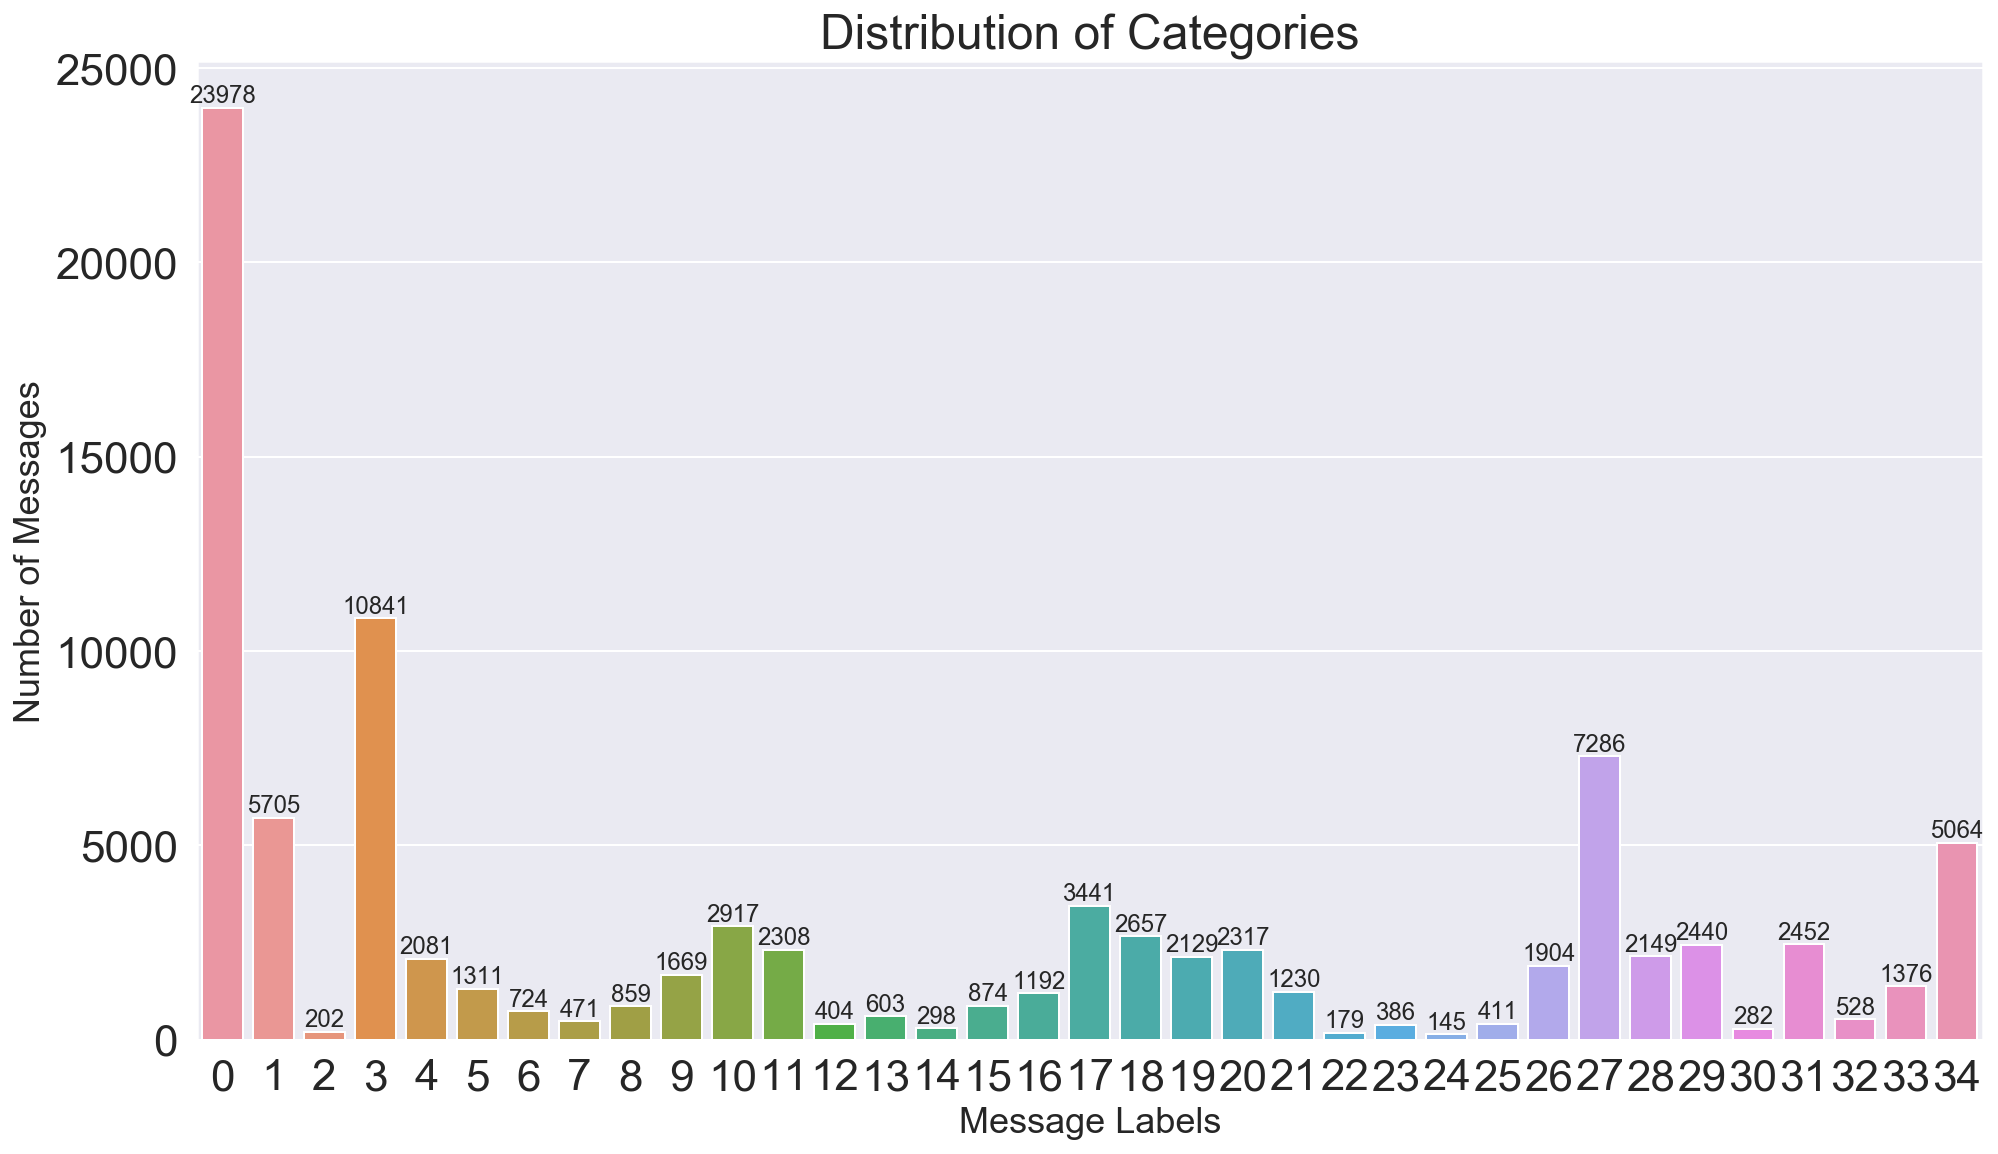

In [342]:
cats = list(range(categories_sampled.shape[1])) # replace the name of categories into numbers
counts = categories_sampled.sum().values
sns.set(font_scale = 2)
plt.figure(figsize=(16,9))
ax= sns.barplot(cats, counts)
plt.title("Distribution of Categories", fontsize=24)
plt.ylabel('Number of Messages', fontsize=18)
plt.xlabel('Message Labels', fontsize=18)
#adding the text labels
rects = ax.patches
for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, count, ha='center', va='bottom', fontsize=12)
plt.show()

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.